In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from keras.applications import ResNet50 , VGG16
from keras.layers import GlobalAveragePooling2D, Dense , Dropout , UpSampling2D , Flatten , BatchNormalization
from keras.models import Model , Sequential
from keras.datasets import cifar10
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Load CIFAR-10 dataset and split into training and testing sets
(X_train , y_train) , (X_test , y_test) = cifar10.load_data()

# Normalize pixel values to the range [0, 1]
X_train , X_test = X_train / 255.0 , X_test / 255.0

# Print shapes of training and testing data arrays along with their labels
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

170498071/170498071 [==============================] - 4s 0us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


In [3]:
# Define class labels for CIFAR-10 dataset
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



# One-hot encode target labels
y_train_encoded = to_categorical(y_train, num_classes=10)
y_test_encoded = to_categorical(y_test, num_classes=10)





In [4]:
from tensorflow.keras.callbacks import  ModelCheckpoint



# Create callbacks including the learning rate scheduler
callbacks = [
    ModelCheckpoint("res_model_NOaug.keras", save_best_only=True),  # Save the best model during training
]


In [5]:

convolutional_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))
convolutional_base.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [6]:

# Create a Sequential model
model = Sequential()

# Upsample the input to match ResNet50 input size
model.add(UpSampling2D(size=(2, 2)))  # upsamples to (64, 64, 3)
model.add(UpSampling2D(size=(2, 2)))  # upsamples to (128, 128, 3)
model.add(UpSampling2D(size=(2, 2)))
# Add the ResNet50 base model
model.add(convolutional_base)

# Flatten the output for the fully connected layers
model.add(Flatten())
model.add(BatchNormalization())

# Add some fully connected layers for classification
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout regularization
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout regularization
model.add(BatchNormalization())

# Output layer for classification
model.add(Dense(10, activation='softmax'))


In [7]:



# Clear the TensorFlow session
tf.keras.backend.clear_session()

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=2e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
ResNet50_history = model.fit(X_train,
                             y_train_encoded,
                             batch_size=32,
                             epochs=10,
                             validation_data=(X_test, y_test_encoded),
                             callbacks=callbacks,
                             verbose=1)



Epoch 1/10
1563/1563 [==============================] - 736s 450ms/step - loss: 1.4980 - accuracy: 0.5061 - val_loss: 0.5868 - val_accuracy: 0.8468
Epoch 2/10
1563/1563 [==============================] - 701s 449ms/step - loss: 0.8324 - accuracy: 0.7687 - val_loss: 0.3671 - val_accuracy: 0.9109
Epoch 3/10
1563/1563 [==============================] - 701s 449ms/step - loss: 0.5937 - accuracy: 0.8579 - val_loss: 0.2851 - val_accuracy: 0.9305
Epoch 4/10
1563/1563 [==============================] - 699s 447ms/step - loss: 0.4498 - accuracy: 0.9043 - val_loss: 0.2364 - val_accuracy: 0.9387
Epoch 5/10
1563/1563 [==============================] - 702s 449ms/step - loss: 0.3435 - accuracy: 0.9315 - val_loss: 0.2171 - val_accuracy: 0.9411
Epoch 6/10
1563/1563 [==============================] - 702s 449ms/step - loss: 0.2601 - accuracy: 0.9526 - val_loss: 0.2035 - val_accuracy: 0.9464
Epoch 7/10
1563/1563 [==============================] - 698s 447ms/step - loss: 0.2079 - accuracy: 0.9655 - val_

In [8]:

# Evaluate the model
resnet50_test_loss, resnet50_test_accuracy = model.evaluate(X_test, y_test_encoded)
print("ResNet-50 Test Accuracy:", resnet50_test_accuracy)

313/313 [==============================] - 36s 116ms/step - loss: 0.2104 - accuracy: 0.9463
ResNet-50 Test Accuracy: 0.9463000297546387


In [9]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


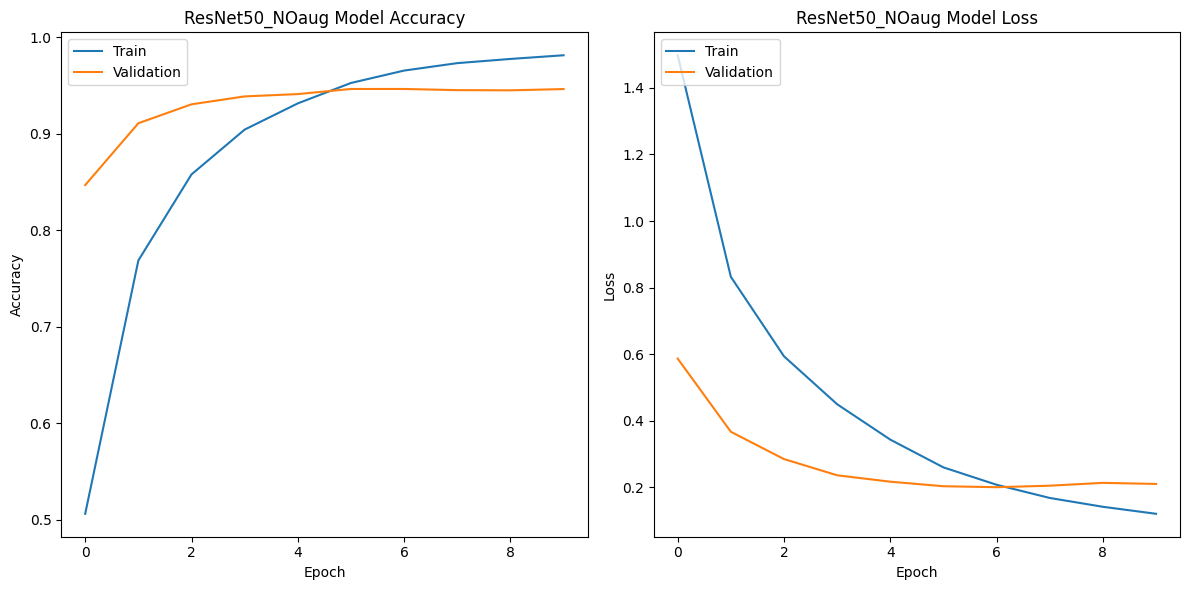

In [10]:
plot_history(ResNet50_history, 'ResNet50_NOaug')
